$\newcommand{\a}{\alpha}$ $\newcommand{\s}{\sigma}$ $\newcommand{\half}{\frac{1}{2}}$ $\newcommand{\F}{\mathcal{F}} \newcommand{\P}{\mathbb{P}}$ $\newcommand{\par}{\partial}$ $\newcommand{\R}{\mathbb{R}}$
$\newcommand{\argmin}{\arg\!\min}$ $\newcommand{\E}{\mathbb E}$$\newcommand{\lb}{\left [}$$\newcommand{\rb}{\right ]}$

**Run this cell!**

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import sys
sys.path.insert(0, '/Users/finn/Desktop/Capstone-BSDE/files/code')

In [2]:
import european_option
import Liquidation1
import LSMC

### 3.3A 
Example 1: European Option Pricing

Consider some risky asset that satisfies the following forward SDE under real-world measure $\mathbb P$
$$
    dS_t = \mu_t S_t dt + \s_t S_t dW_t^\P
$$
where, for simplicity, we assume
* $d = d_1=d_2 = 1$
* $\mu_t = 0.1$, the constant drift
* $r_t=0.03$, the constant interest rate
* $\s_t=0.3$, the constant volatility
* $S_0 =20$, the initial stock price
* $T=1$, the time to maturity
* $K=30$, the strike price

Now, we will use the least square regression scheme in section $3.3$ for backward SDE $(1.3.1)$ with final condition

\begin{align*}
    Y_T &= (S_T - K)^+\\
    dY_t &= \lb(\mu_t - r_t)\Pi_t + r_tY_t \rb dt + \sigma_t \Pi_t dW_t  = \lb\frac{(\mu_t - r_t)}{\s_t}Z_t + r_tY_t \rb dt + Z_t dW_t \tag{1.3.1}
\end{align*}
In this case,
$$
    f(s, y, z) :=  -\lb \frac{(\mu_t - r_t)}{\s_t}z + r_ty \rb = -\frac{7}{30}z - 0.03y
$$

we will choose the following parameters for Monte-Carlo
* $M = 2^{19}$
* $N = 100$
* $\Delta t= \frac{T}{N}=0.01$
* $k_n = 6, \quad \forall n=1,...,N-1$

with the basis function
$$
    \{ \phi_i^{(n)}\}:= \{1, x, x^2, x^3, x^4, x^5\},\quad \forall n=1,...,N-1
$$

In [3]:
# Market Parameters
mu = 0.03
r = 0.03
sig = 0.8
s0 = np.array([40])
T = 1
K = 30

# Simulation parameters
dt = 1/252.
M = 2 ** 14
N = int(T/dt)
d = 1
d1 = 1
d2 = 1
dZ = LSMC.generate_z_matrix(n_paths=M, n_steps=N, d_bm=d)

# LSMC
basis_funcs = [lambda x, coef=i: x ** coef for i in range(3)]

S_sim = european_option.S_t(mu, sig, d, d1)
Y_sim = european_option.Y_t(mu, r, sig, d2, K)

LSMC_solver = LSMC.LSMC_linear(Y_sim, S_sim, dZ, s0, dt, reg_method=None, basis_funcs_type='poly')
# LSMC_solver = LSMC.LSMC_svm(Y_sim, S_sim, dZ, s0, dt, basis_funcs_type='trig')

LSMC_solver.solve()

# Pricing with LSMC of FBSDE
print(LSMC_solver.y0[0])
print(european_option.BS_EuroCall(S=s0, T=T, K=K, r=r, q=0, sig=sig)[0])

16.953989792687004
16.969140024873884


In [4]:
def show_result_path(method="linear", M=[2**i for i in range(4, 20)]):
    x = [np.log2(m) for m in M]
    p_OLS = []
    p_ridge = []
    p_svm = []
    
    for m in M:
        dZ = LSMC.generate_z_matrix(n_paths=m, n_steps=N, d_bm=d)
        if method=='linear':
            LSMC_solver_OLS = LSMC.LSMC_linear(Y_sim, S_sim, dZ, s0, dt, reg_method=None, basis_funcs_type='poly')
            LSMC_solver_OLS.solve()
            LSMC_solver_ridge = LSMC.LSMC_linear(Y_sim, S_sim, dZ, s0, dt, {'fit_intercept': False}, reg_method='ridge', basis_funcs_type='poly')
            LSMC_solver_ridge.solve()
            p_OLS.append(LSMC_solver_OLS.y0[0])
            p_ridge.append(LSMC_solver_ridge.y0[0])
            
        elif method=='SVM':
            LSMC_solver_svm = LSMC.LSMC_svm(Y_sim, S_sim, dZ, s0, dt, basis_funcs_type='trig', kernel='linear')
            LSMC_solver_svm.solve()
            p_svm.append(LSMC_solver_svm.y0[0])
            
    if method == 'linear':
        return x, p_OLS, p_ridge
    elif method == 'SVM':
        return x, p_svm


In [5]:
x, p_OLS, p_ridge = show_result_path()

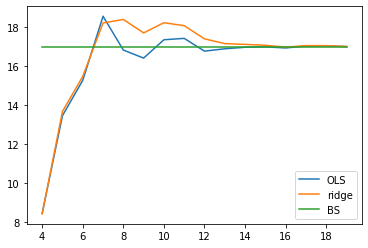

In [6]:
BS_price = european_option.BS_EuroCall(S=s0, T=T, K=K, r=r, q=0, sig=sig)[0]

plt.plot(x, p_OLS, label='OLS')
plt.plot(x, p_ridge, label='ridge')
plt.plot(x, [BS_price]*len(x), label='BS')
plt.legend()
plt.show()

In [8]:
# x, p_svm = show_result_path(method="SVM", M=[2**10, 2**11, 2**12])

In [9]:
# plt.plot(x, p_svm, label='SVM')
# plt.plot(x, [BS_price]*len(x), label='BS')
# plt.legend()
# plt.show()